# Distributed Search

This notebook and accompanying code shows how to run an Archai Network Architecture Search (NAS) using
an Azure Machine Learning Workspace with distributed partial training of models on a GPU cluster.
This example requires a storage account and Azure machine learning workspace specified in a config.json
file like this:

```json
{
    "subscription_id": "...",
    "resource_group": "...",
    "workspace_name": "...",
    "storage_account_key": "...",
    "storage_account_name": "..."
}
```

In [1]:
import sys
import os
import json
import archai.common.azureml_helper as aml_helper
from azure.ai.ml.entities import UserIdentityConfiguration

sys.path.append(os.path.realpath('scripts'))

# make sure we have a scripts dir for the code to run our jobs.
import os
scripts_dir = "./scripts"
os.makedirs(scripts_dir, exist_ok=True)

config_file = "../.azureml/config.json"
config = json.load(open(config_file, 'r'))

for required_key in ['subscription_id', 'resource_group', 'workspace_name', 'storage_account_key', 'storage_account_name']:
    if not required_key in config:
        print(f"### Error: please add a {required_key} to {config_file}")

storage_account_key = config['storage_account_key']    
storage_account_name = config['storage_account_name']

print(f'Using storage account: {storage_account_name}')

# This is the AML experiment name 
experiment_name = 'mnist_test_run'

Using storage account: archaimnistmodels


Our [search.py](scripts/search.py) will use a ConfigSearchSpace based on the following parameters, the model defined in [model.py](scripts/model.py) will take various configurations and build different shape CNN models for each configuration as shown below. Each time you execute this cell it will generate a new random CNN model.

In [2]:
from archai.discrete_search.search_spaces.config import ArchParamTree, DiscreteChoice
from model import MyModel

arch_param_tree = ArchParamTree({
    'nb_layers': DiscreteChoice(list(range(1, 13))),
    'kernel_size': DiscreteChoice([1, 3, 5, 7]),
    'hidden_dim': DiscreteChoice([16, 32, 64, 128])
})

arch_config = arch_param_tree.sample_config()
print(arch_config)

MyModel(arch_config)

ArchConfig({
    "nb_layers": 1,
    "kernel_size": 5,
    "hidden_dim": 32
})


MyModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveAvgPool2d(output_size=(1, 1))
    (4): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)

Get a handle to the workspace

In [3]:
ml_client = aml_helper.get_aml_client_from_file(config_path=config_file)
print(f'Using workspace "{ml_client.workspace_name}" in resource group "{ml_client.resource_group_name}"')

Found the config file in: ..\.azureml\config.json


Using workspace "snpe-aml-workspace" in resource group "snpe-aml-rg"


Create the compute clusters that we need

In [4]:
# Create cpu cluster for running the search
cpu_compute_name = "nas-cpu-cluster-D14-v2"
aml_helper.create_compute_cluster(ml_client, cpu_compute_name, size="Standard_D14_v2", location="westus2")

# Create gpu cluster for running the search
gpu_compute_name = "nas-gpu-cluster-NC6"
aml_helper.create_compute_cluster(ml_client, gpu_compute_name, size="Standard_NC6", location="westus2", max_instances=8)

You already have a cluster named nas-cpu-cluster-D14-v2, we'll reuse it as is.
You already have a cluster named nas-gpu-cluster-NC6, we'll reuse it as is.


Create the AML Environment from our conda.yaml file

In [5]:
archai_job_env = aml_helper.create_environment_from_file(ml_client, conda_file="conda.yaml", version='0.1.7')

Environment with name aml-archai is registered to workspace, the environment version is 0.1.7


Ensure our storage account is setup with `models` blob store container and `status` table

In [6]:
from store import ArchaiStore

# Register the datastore with AML
data_store_name = "datasets"
data_container_name = "datasets"
model_store_name = "models"
model_container_name = "models"
root_folder = experiment_name

# make sure the datasets container exists
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=data_container_name)
store.upload_blob(root_folder, config_file)

# make sure the models container exists
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=model_container_name)
store.upload_blob("config", config_file)

datastore_path = f'azureml://datastores/{data_store_name}/paths/{root_folder}'
results_path = f'azureml://datastores/{model_store_name}/paths/{root_folder}'

Register the `models` blob store container in the ML workspace `datastores`

In [7]:
from azure.ai.ml.entities import AzureBlobDatastore
from azure.ai.ml.entities._credentials import AccountKeyConfiguration

try:
    model_store = ml_client.datastores.get(model_store_name)
except:    
    model_store = AzureBlobDatastore(
        name=model_store_name,
        description="Datastore pointing to our models blob container.",
        account_name=storage_account_name,
        container_name=model_container_name,
        credentials=AccountKeyConfiguration(
            account_key=storage_account_key
        ),
    )

    ml_client.create_or_update(model_store)

Register the `datasets` blob store container in the ML workspace `datastores`

In [8]:
try:
    data_store = ml_client.datastores.get(data_store_name)
except:
    data_store = AzureBlobDatastore(
        name=data_store_name,
        description="Datastore pointing to our dataset container.",
        account_name=storage_account_name,
        container_name=data_container_name,
        credentials=AccountKeyConfiguration(
            account_key=storage_account_key
        ),
    )

    ml_client.create_or_update(data_store)

Create a pipeline command that prepares our MNIST dataset using `prep_data_store.py`

In [9]:
from azure.ai.ml import command
from azure.ai.ml import Input, Output

data_prep_component = command(
    name="data_prep2",
    display_name="Data preparation for training",
    description="Downloads the remote dataset to our blob store.",
    inputs= {
        "name": Input(type='string')
    },
    outputs= {
        "data": Output(type="uri_folder", path=datastore_path, mode="rw_mount")
    },

    # The source folder of the component
    code=scripts_dir,
    command="""python3 prep_data_store.py \
            --path ${{outputs.data}} \
            """,
    environment=f"{archai_job_env.name}:{archai_job_env.version}",
)

Create a command that kids of the Archai Search using `search.py`

In [10]:
environment_name = f'{archai_job_env.name}:{archai_job_env.version}'
hex_config = bytes(json.dumps(config), encoding='utf-8').hex()

partial_epochs = 0.1
full_epochs = 10

output_path = results_path + '/' + experiment_name
fixed_args = f'--data_dir {datastore_path} ' + \
             f'--output_dir {results_path} ' + \
             f'--environment "{environment_name}" ' + \
             f'--experiment "{experiment_name}" ' + \
             f'--compute "{gpu_compute_name}" ' + \
             f'--config "{hex_config}" ' + \
             f'--partial_training_epochs {partial_epochs} ' + \
             f'--full_training_epochs {full_epochs} '

print(fixed_args)

search_component = command(
    name="search",
    display_name="The Archai NAS search",
    description="Runs the NAS search algorithm.",    
    inputs= {
        "data": Input(type="uri_folder")
    },
    outputs= {
        "results": Output(type="uri_folder", path=output_path, mode="rw_mount")
    },
    code=scripts_dir,
    identity= UserIdentityConfiguration(),
    command='python3 search.py --local_output ${{outputs.results}} ' + \
        fixed_args,
    environment=f"{archai_job_env.name}:{archai_job_env.version}",
)

--data_dir azureml://datastores/datasets/paths/mnist_test_run --output_dir azureml://datastores/models/paths/mnist_test_run --environment "aml-archai:0.1.7" --experiment "mnist_test_run" --compute "nas-gpu-cluster-NC6" --config "7b22737562736372697074696f6e5f6964223a202263386237663931332d363066622d343735392d613331302d666335363330653536663939222c20227265736f757263655f67726f7570223a2022736e70652d616d6c2d7267222c2022776f726b73706163655f6e616d65223a2022736e70652d616d6c2d776f726b7370616365222c2022696f745f7265736f757263655f67726f7570223a2022736e70652d6465766963652d6875622d7267222c2022696f745f6875625f6e616d65223a20224d7372536e7065446576696365487562222c20226c6f636174696f6e223a202277657374757332222c202273746f726167655f6163636f756e745f6b6579223a202279485a4459454c3045774a65754c54517747395047713867564f6d78777031593836686e54367239735732666659535967686f4c496a694973712f4353454e45766471785a78546b713872482b4153747548445944773d3d222c202273746f726167655f6163636f756e745f6e616d65223a20226172636861696d6e697

Create an AML pipeline with the data prep and search components piping the output of the data prep to the search component.

In [11]:
from azure.ai.ml import dsl, Input, Output

@dsl.pipeline(
    compute=cpu_compute_name,
    description="Data prep pipeline",
)
def mnist_search_pipeline():
    # using data_prep_function like a python call with its own inputs
    data_prep_job = data_prep_component(
        name="MNIST"
    )

    # check the dataset
    check_job = search_component(
        data=data_prep_job.outputs.data
    )
    
    return { "data": data_prep_job.outputs.data }

Run the search pipeline

In [12]:
pipeline = mnist_search_pipeline()

# submit the pipeline job
pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name=experiment_name,
)



Uploading scripts (0.05 MBs): 100%|##########| 48835/48835 [00:01<00:00, 41929.89it/s]




NameError: name 'printf' is not defined

Open the pipeline azure ML studio portal in your web browser (This works when you are running this notbook in VS code).

In [14]:
import webbrowser
webbrowser.open(pipeline_job.services["Studio"].endpoint)

job_name = pipeline_job.name
print(f'Started pipeline: {job_name}')
# you can fetch this pipeline job again if you needed to restart this notebook using:
pipeline_job = ml_client.jobs.get(job_name)

Started pipeline: green_rabbit_xrrr45dcpn


## Plots

Take a look at the pareto curve plots.  This cell can be run multiple times and you will see updates as each iteration finishes.
You can even run this later after restarting the jupyter notebook because it is not dependent on variable state it is only
dependent on the persistent 'models' blob store.

Fetching results for mnist_test_run...
### Error downloading to local file: [Errno 2] No such file or directory: 'mnist_test_run\\pareto_models_iter_1/1c49cd4b3c29c4482bbd8ace9d40955431a257ca.json'
### Error downloading to local file: [Errno 2] No such file or directory: 'mnist_test_run\\pareto_models_iter_1/210e69e2747f166859b1f50833b84eefc24c8f81.json'
### Error downloading to local file: [Errno 2] No such file or directory: 'mnist_test_run\\pareto_models_iter_1/38d8c718b0cbc2bb15e31f117035c044e8b6099c.json'
### Error downloading to local file: [Errno 2] No such file or directory: 'mnist_test_run\\pareto_models_iter_1/7aaeb315c1f7311c887725adca7ada25c8c255c7.json'
### Error downloading to local file: [Errno 2] No such file or directory: 'mnist_test_run\\pareto_models_iter_1/7bcef7573b94dfad8512daa2b287475967cd6909.json'
### Error downloading to local file: [Errno 2] No such file or directory: 'mnist_test_run\\pareto_models_iter_1/a01e51b6b0e5bc8245b8b1b672173436931d8e68.json'
### Err

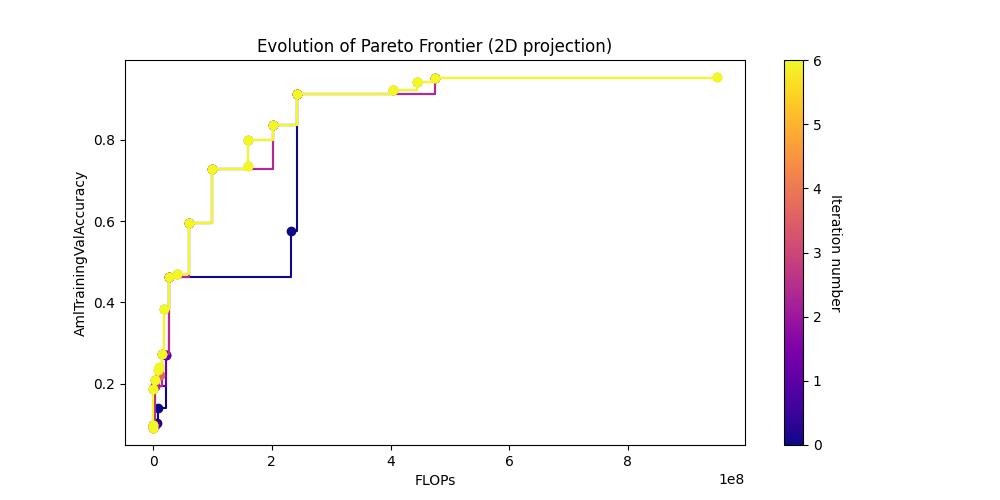

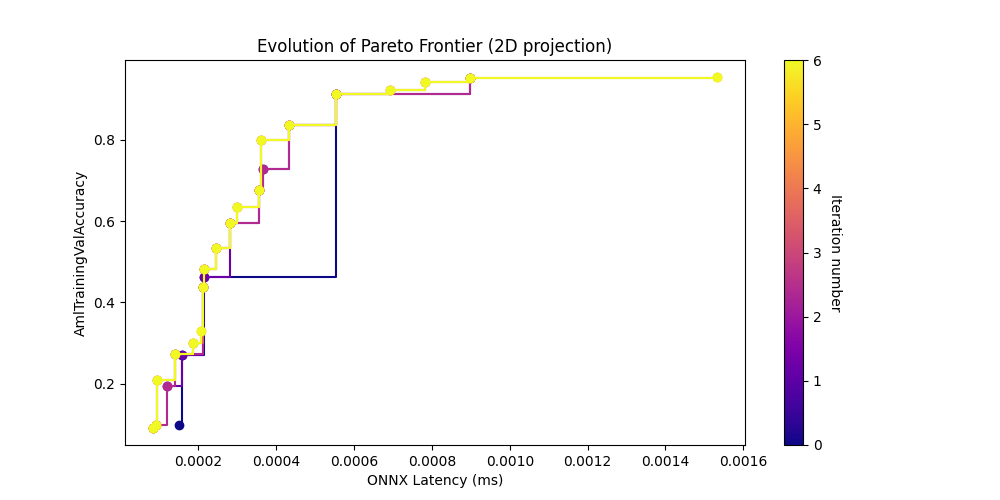

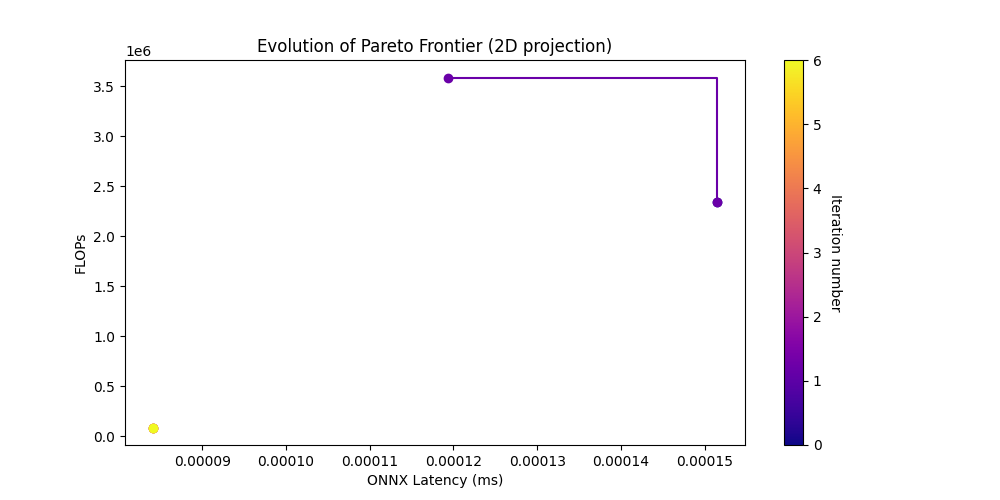

In [17]:
from results import get_results, show_results, download_best_models
from store import ArchaiStore
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=model_container_name)

print(f'Fetching results for {experiment_name}...')
blob_path = root_folder + '/' + experiment_name
output_folder = experiment_name

get_results(store, blob_path, output_folder)
show_results(output_folder)
download_best_models(store, experiment_name, output_folder)
    

## Test ONNX Runtime Inference on the Best Model

When the search pipeline completes you should have a `top_models.json` file in the experiment_name output folder and you can use that to find the most accurate model and run it through the ONNX runtime to see if the ONNX inference gets the same accuracy.

In [20]:
# find the top model in the json results.
filename = os.path.join(output_folder, "top_models.json")
best_of_the_best = None
top_accuracy = 0
row = None
if not os.path.isfile(filename):
    raise Exception(f"Could not find {filename} file. Please wait for job to finish.")

results = json.load(open(filename, "r"))
models = results['top_models']
for a in models:
    if type(a) is dict and 'val_acc' in a:
        val_acc = a['val_acc']
        if val_acc > top_accuracy:
            top_accuracy = val_acc
            best_of_the_best = a['job_id']
            row = a

arch = f"nb_layers={row['nb_layers']}, kernel_size={row['kernel_size']}, hidden_dim={row['hidden_dim']}"
print(f"The top model is {best_of_the_best} with accuracy {top_accuracy} and architecture {arch}")

blob_path = root_folder + '/' + best_of_the_best
model_output = os.path.join(output_folder, 'top_model')
get_results(store, blob_path, model_output)

model_path = os.path.join(model_output, 'model.onnx')


The top model is id_cede8c68_6268_4fc5_bb65_f557b051800e with accuracy 0.9957 and architecture nb_layers=7, kernel_size=7, hidden_dim=32


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataroot\MNIST\raw\train-images-idx3-ubyte.gz to dataroot\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataroot\MNIST\raw\train-labels-idx1-ubyte.gz to dataroot\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataroot\MNIST\raw\t10k-images-idx3-ubyte.gz to dataroot\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataroot\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataroot\MNIST\raw

data has shape: torch.Size([28, 28])


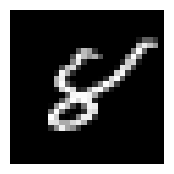

input: input, [1, 1, 28, 28], tensor(float)
Testing 10000 rows


c:\anaconda3\envs\archai\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Failed 43 out of 10000 rows
Inference pass rate is  99.57 %.
How does this compare with the training validation accuracy of 0.9957
Success! The model is working as expected.


In [21]:
# Great, now let's test if this model works as advertised.
from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider
import onnxruntime as ort
import numpy as np

dataset_provider = MnistDatasetProvider()
val_data = dataset_provider.get_val_dataset()
count = val_data.data.shape[0]
test = np.random.choice(count, 1)[0]
data = val_data.data[test]

import matplotlib.pyplot as plt

# check what the images look like.
plt.figure(figsize=(2,2))
plt.imshow(data, cmap='gray')
print(f'data has shape: {data.shape}')
plt.axis('off')
plt.show()

# Now run the ONNX runtime on this the validation set.
# You can change this to `CUDAExecutionProvider` if you have a GPU and have
# installed the CUDA runtime.
ort_sess = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
for i in ort_sess.get_inputs():
    print(f'input: {i.name}, {i.shape}, {i.type}')
    
print(f'Testing {count} rows')
failed = 0
for i in range(val_data.data.shape[0]):
    data = val_data.data[i]    
    expected = int(val_data.train_labels[i])

    while len(data.shape) < 4:
        data = np.expand_dims(data, axis=0)
    outputs = ort_sess.run(None, {'input': data.astype(np.float32) / 255.0})
    result = outputs[0]
    index = np.argmax(result)
    label = val_data.classes[index]
    if expected != index:
        # print(f'### Failed: {expected} and got {label}')
        failed += 1
          
rate = (count - failed) * 100 / count
print(f"Failed {failed} out of {count} rows")
print(f'Inference pass rate is  {rate} %.')
print(f'How does this compare with the training validation accuracy of {top_accuracy}')
if np.isclose(rate, top_accuracy* 100, atol=0.1):
    print('Success! The model is working as expected.')
else:
    print('The onnx runtime is giving different results.')
